# deliriumviz.py


In [ ]:
def corrections_loader(fecha_inicio, fecha_fin):
    import pandas as pd
    import os
    from datetime import datetime, timedelta
    from zoneinfo import ZoneInfo
    from bs4 import BeautifulSoup
    import re

    zona_local="America/Santiago"
    ruta_base = "$repository/data/"
    nombre_base = "corrections_report"
    formato_fecha = "%Y-%m-%d" 

    # Convertir fechas a UTC
    dt_inicio_utc = fecha_inicio.replace(tzinfo=ZoneInfo(zona_local)).astimezone(ZoneInfo("UTC"))
    dt_fin_utc = fecha_fin.replace(tzinfo=ZoneInfo(zona_local)).astimezone(ZoneInfo("UTC"))

    # Recorrer fechas y procesar archivos HTML

    resultados = []

    fecha_actual = fecha_inicio
    while fecha_actual <= fecha_fin:
        fecha_str = fecha_actual.strftime(formato_fecha)
        anio = fecha_actual.strftime("%Y")                
        mes = fecha_actual.strftime("%m")
        nombre_archivo = f"{nombre_base}_{fecha_str}.html"                 
        path = os.path.join(ruta_base, anio, mes, f"{nombre_base}_{fecha_str}.html")


        if os.path.exists(path):
            with open(path, "r", encoding="utf-8") as f:
                html = f.read()
                soup = BeautifulSoup(html, "lxml")
                # Función que extrae tablas de un archivo HTML y las devuelve como una lista de DataFrames
                tablas = pd.read_html(path, index_col=0)
                # Tablas impares con la información de 
                for i in range(0, len(tablas) - 1, 2):
                    # Número de filas que tiene tablas[1]
                    n_repeat = tablas[i + 1].shape[0]
                    # Nuestra intención es extraer la información de "Timestamp" y "Delay line number" para agregarlas como columnas nuevas
                    tabla_transpuesta = tablas[i].T
                    if all(col in tabla_transpuesta.columns for col in ["Timestamp", "Delay line number"]):
                        test_pd = tabla_transpuesta[["Timestamp", "Delay line number"]].copy()
                        # Hace que los Timestamp pasen a formato datetime64 (formato de fecha y hora estandarizado)
                        test_pd["Timestamp"] = pd.to_datetime(test_pd["Timestamp"])

                        # Validamos que test_pd no esté vacío y que n_repeat sea mayor que 0
                        if not test_pd.empty and n_repeat > 0:
                            # Concatenamos el dataframe a que se repita la misma cantidad de veces que el n° de correcciones y limpiamos el índice
                            test_pd_repeated = pd.concat([test_pd] * n_repeat).reset_index(drop=True)
                            # Eliminamos el nivel 0 del índice de columnas, Cambiamos el nombre del índice a "Rail number" y lo movemos de columna
                            tabla_correcciones = tablas[i + 1].droplevel(0, axis=1).rename_axis("Rail number").reset_index(drop=False)
                            # "Tunnel Relative Humidity" se encuentra como la etiqueta h3
                            h3_tags = soup.find_all("h3")
                            h3_texts = [tag.text for tag in h3_tags]

                            # Extraemos el porcentaje de humedad del texto
                            humidity = None
                            for tag in h3_tags:
                                texto = tag.get_text()
                                match = re.search(r"(\d+(\.\d+)?)%", texto)
                                if match:
                                    porcentaje = match.group(1)
                                    humidity = float(porcentaje)
                                    break

                            # Creamos una tabla 
                            if humidity is not None:
                                porc_pd_repeated = pd.DataFrame({"Tunnel Relative Humidity": [f"{humidity}%"] * n_repeat})
                            else:
                                porc_pd_repeated = pd.DataFrame({"Tunnel Relative Humidity": [None] * n_repeat})

                            pd_result = pd.concat([test_pd_repeated, porc_pd_repeated, tabla_correcciones], axis=1)

                            # Concatenamos ambas tablas anteriormente realizadas
                            print(pd_result)
                            print(f"Archivo procesado: {nombre_archivo}")

                            resultados.append(pd_result)
                        else:
                            print(f"test_pd vacío o n_repeat = 0 en archivo {nombre_archivo}")
                    else:
                        print(f"Columnas faltantes en tabla {i} del archivo {nombre_archivo}")
        else:
            print(f"Archivo no encontrado: {nombre_archivo}")

        fecha_actual += timedelta(days=1)

    # Exportar a Excel
    df_final = pd.concat(resultados, ignore_index=True)
    df_final["Timestamp"] = df_final["Timestamp"].dt.strftime("%Y-%m-%d %H:%M") # Transformamos a string las fechas para poder verlas en excel
    df_final.to_excel("resultados.xlsx", index=False)

    return df_final
        

In [2]:
def heatmap(df_final):
    import matplotlib.pyplot as plt
    import seaborn as sns

    # Formato datetime asegurado
    if not pd.api.types.is_datetime64_any_dtype(df_final["Timestamp"]):
        df_final["Timestamp"] = pd.to_datetime(df_final["Timestamp"])
    df_final["Fecha"] = df_final["Timestamp"].dt.date


    for fecha in sorted(df_final["Timestamp"].dt.date.unique()):
        df_dia = df_final[df_final["Timestamp"].dt.date == fecha].copy()

        # Agrupar rieles en intervalos de 5
        df_dia["rail_bin"] = pd.cut(df_dia["Rail number"], bins=range(0, df_dia["Rail number"].max() + 10, 5))

        # Crear tabla de conteo
        tabla = pd.crosstab(df_dia["Delay line number"], df_dia["rail_bin"])

        # Gráfico heatmap 1 (separado por días)
        plt.figure(figsize=(12, 6))
        ax = sns.heatmap(tabla, annot=True, fmt="d", cmap="YlGnBu", linewidths=0.5,
                     cbar_kws={"label": "Cantidad de ajustes"})

        plt.title(f"Mapa de calor: Ajustes por línea de retardo - {fecha}")
        plt.xlabel("Grupo de rieles")
        plt.ylabel("Línea de retardo")
        plt.tight_layout()
        plt.show()

    df_final["Fecha"] = df_final["Timestamp"].dt.date

    # Tabla pivote con la mediana de Rail number
    tabla_medianas = df_final.pivot_table(
        index="Delay line number",
        columns="Fecha",
        values="Rail number",
        aggfunc="median" # Se solicitó hacerlo con esta función pensando en 20 días
    )

    # Gráfico heatmap 2 (mediana agrupada por días)
    plt.figure(figsize=(14, 6))
    sns.heatmap(tabla_medianas, annot=True, fmt=".1f", cmap="YlOrRd", linewidths=0.5,
                cbar_kws={"label": "Mediana del número de riel"})

    plt.title("Mapa de calor: Mediana del número de riel por día y línea de retardo")
    plt.xlabel("Fecha")
    plt.ylabel("Línea de retardo")
    plt.tight_layout()
    plt.show()

## Directories
### Folders are structured in YYYY/MM
### There are missing days, this is not an error.
### File names follows the rule corrections_report_YYYY-MM-DD.html
### The full path to a correction file is $repository/data/YYYY/MM/corrections_report_YYYY-MM-DD.html

# Pruebas de código por separado

In [3]:
# Librerías
import pandas as pd
import os
from datetime import datetime, timedelta
from zoneinfo import ZoneInfo
from bs4 import BeautifulSoup
import re
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
zona_local="America/Santiago"
ruta_base = "C:/Users/catal/Downloads/collaborations-2025-delirium-visualization-main/collaborations-2025-delirium-visualization-main/data/"
nombre_base = "corrections_report"
formato_fecha = "%Y-%m-%d" 

In [5]:
# Parámetros de entrada
fecha_inicio = datetime(2022, 7, 10)
fecha_fin = datetime(2022, 7, 15)

# Convertir fechas a UTC
dt_inicio_utc = fecha_inicio.replace(tzinfo=ZoneInfo(zona_local)).astimezone(ZoneInfo("UTC"))
dt_fin_utc = fecha_fin.replace(tzinfo=ZoneInfo(zona_local)).astimezone(ZoneInfo("UTC"))

In [7]:
# Recorrer fechas y procesar archivos HTML
# Oculto en funciones

resultados = []

fecha_actual = fecha_inicio
while fecha_actual <= fecha_fin:
    fecha_str = fecha_actual.strftime(formato_fecha)
    anio = fecha_actual.strftime("%Y")              
    mes = fecha_actual.strftime("%m") 

    nombre_archivo = f"{nombre_base}_{fecha_str}.html"               

    path = os.path.join(ruta_base, anio, mes, f"{nombre_base}_{fecha_str}.html")


    if os.path.exists(path):
        with open(path, "r", encoding="utf-8") as f:
            html = f.read()
            soup = BeautifulSoup(html, "lxml")
            # Función que extrae tablas de un archivo HTML y las devuelve como una lista de DataFrames
            tablas = pd.read_html(path, index_col=0)
            # Tablas impares con la información de 
            for i in range(0, len(tablas) - 1, 2):
                # Número de filas que tiene tablas[1]
                n_repeat = tablas[i + 1].shape[0]
                # Nuestra intención es extraer la información de "Timestamp" y "Delay line number" para agregarlas como columnas nuevas
                tabla_transpuesta = tablas[i].T
                if all(col in tabla_transpuesta.columns for col in ["Timestamp", "Delay line number"]):
                    test_pd = tabla_transpuesta[["Timestamp", "Delay line number"]].copy()
                    # Hace que los Timestamp pasen a formato datetime64 (formato de fecha y hora estandarizado)
                    test_pd["Timestamp"] = pd.to_datetime(test_pd["Timestamp"])

                    # Validamos que test_pd no esté vacío y que n_repeat sea mayor que 0
                    if not test_pd.empty and n_repeat > 0:
                        # Concatenamos el dataframe a que se repita la misma cantidad de veces que el n° de correcciones y limpiamos el índice
                        test_pd_repeated = pd.concat([test_pd] * n_repeat).reset_index(drop=True)

                        # Eliminamos el nivel 0 del índice de columnas, Cambiamos el nombre del índice a "Rail number" y lo movemos de columna
                        tabla_correcciones = tablas[i + 1].droplevel(0, axis=1).rename_axis("Rail number").reset_index(drop=False)

                        # "Tunnel Relative Humidity" se encuentra como la etiqueta h3
                        h3_tags = soup.find_all("h3")
                        h3_texts = [tag.text for tag in h3_tags]

                        # Extraemos el porcentaje de humedad del texto
                        humidity = None
                        for tag in h3_tags:
                            texto = tag.get_text()
                            match = re.search(r"(\d+(\.\d+)?)%", texto)
                            if match:
                                porcentaje = match.group(1)
                                humidity = float(porcentaje)
                                break

                        # Creamos una tabla 
                        if humidity is not None:
                            porc_pd_repeated = pd.DataFrame({"Tunnel Relative Humidity": [f"{humidity}%"] * n_repeat})
                        else:
                            porc_pd_repeated = pd.DataFrame({"Tunnel Relative Humidity": [None] * n_repeat})

                        pd_result = pd.concat([test_pd_repeated, porc_pd_repeated, tabla_correcciones], axis=1)

                        # Concatenamos ambas tablas anteriormente realizadas
                        print(pd_result)
                        print(f"Archivo procesado: {nombre_archivo}")

                        resultados.append(pd_result)
                    else:
                        print(f"test_pd vacío o n_repeat = 0 en archivo {nombre_archivo}")
                else:
                    print(f"Columnas faltantes en tabla {i} del archivo {nombre_archivo}")
    else:
        print(f"Archivo no encontrado: {nombre_archivo}")

    fecha_actual += timedelta(days=1)

            Timestamp Delay line number Tunnel Relative Humidity  Rail number  \
0 2022-07-10 09:54:00                 1                    10.1%           29   
1 2022-07-10 09:54:00                 1                    10.1%           35   
2 2022-07-10 09:54:00                 1                    10.1%           38   
3 2022-07-10 09:54:00                 1                    10.1%           42   
4 2022-07-10 09:54:00                 1                    10.1%           43   
5 2022-07-10 09:54:00                 1                    10.1%           58   
6 2022-07-10 09:54:00                 1                    10.1%           70   
7 2022-07-10 09:54:00                 1                    10.1%           72   
8 2022-07-10 09:54:00                 1                    10.1%           77   

   horizontal  vertical  
0           8         0  
1          10         0  
2           0        -7  
3         -16         0  
4          -9         0  
5           9         0  
6      

In [ ]:
# Exportar a Excel
df_final = pd.concat(resultados, ignore_index=True)
df_final["Timestamp"] = df_final["Timestamp"].dt.strftime("%Y-%m-%d %H:%M") # Transformamos a string las fechas para poder verlas en excel
df_final.to_excel("resultados.xlsx", index=False)

# Gráficos con matplotlib

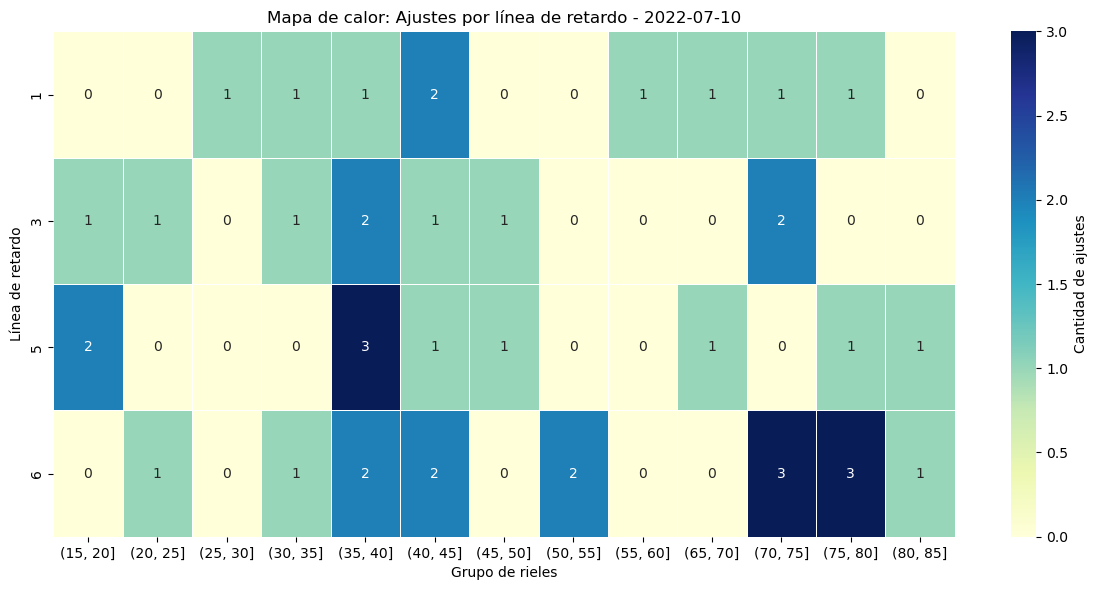

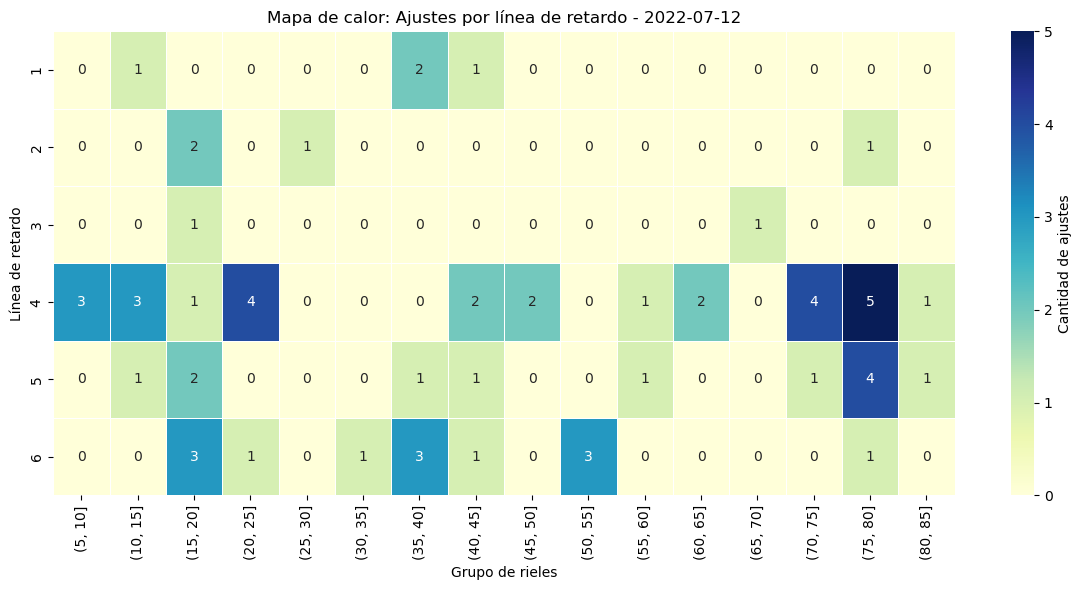

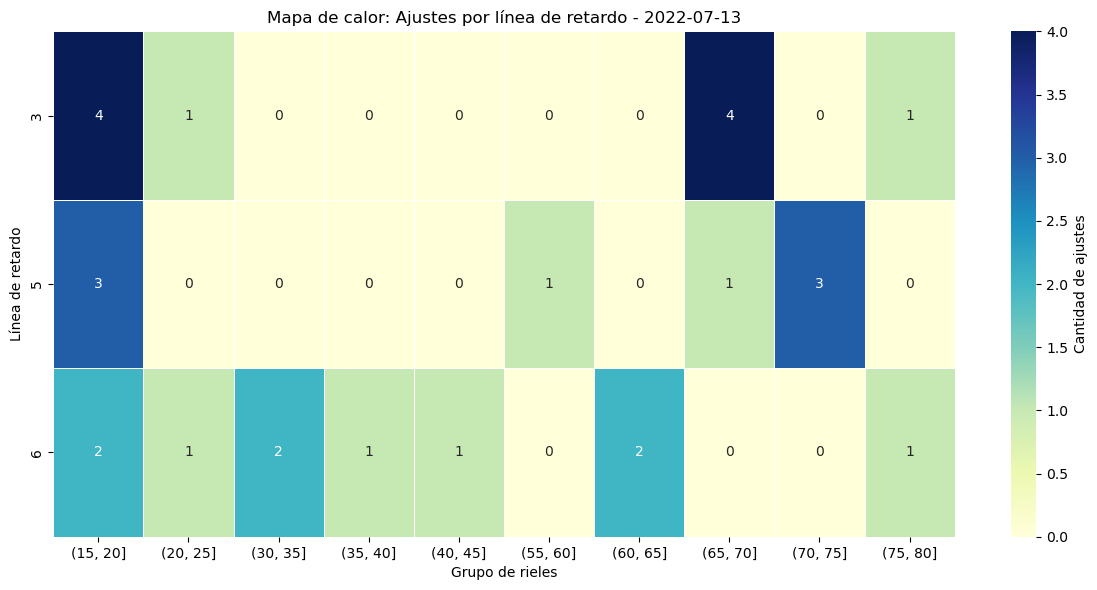

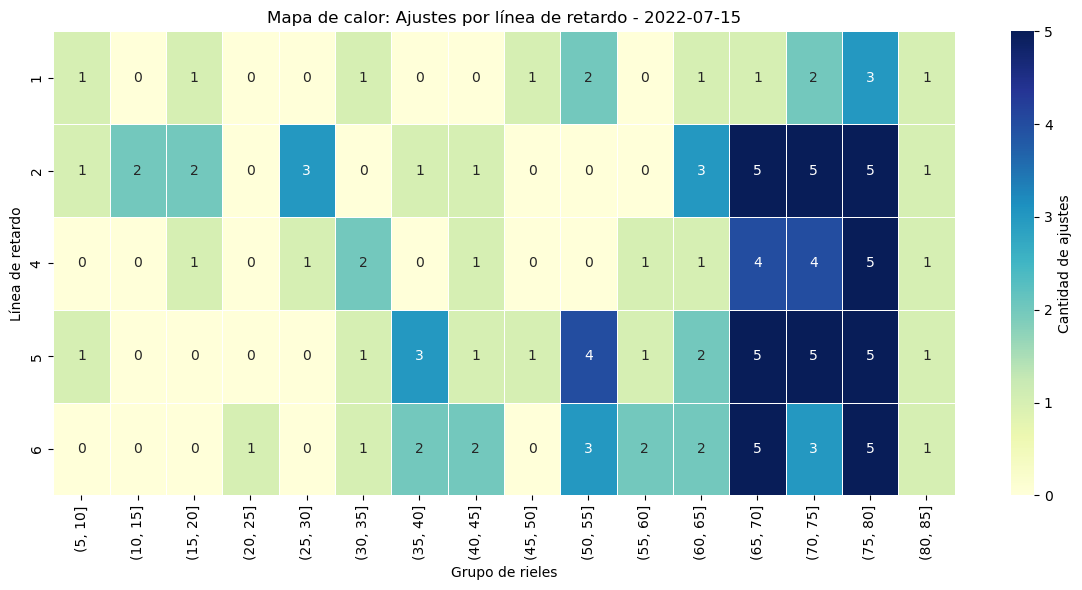

In [ ]:
df_final["Timestamp"] = pd.to_datetime(df_final["Timestamp"])

for fecha in sorted(df_final["Timestamp"].dt.date.unique()):
    df_dia = df_final[df_final["Timestamp"].dt.date == fecha].copy()

    # Rieles en intervalos de 5
    df_dia["rail_bin"] = pd.cut(df_dia["Rail number"], bins=range(0, df_dia["Rail number"].max() + 10, 5))

    # Tabla de conteo
    tabla = pd.crosstab(df_dia["Delay line number"], df_dia["rail_bin"])

    # Graficar heatmap
    plt.figure(figsize=(12, 6))
    ax = sns.heatmap(tabla, annot=True, fmt="d", cmap="YlGnBu", linewidths=0.5,
                     cbar_kws={"label": "Cantidad de ajustes"})

    plt.title(f"Mapa de calor: Ajustes por línea de retardo - {fecha}")
    plt.xlabel("Grupo de rieles")
    plt.ylabel("Línea de retardo")
    plt.tight_layout()
    plt.show()


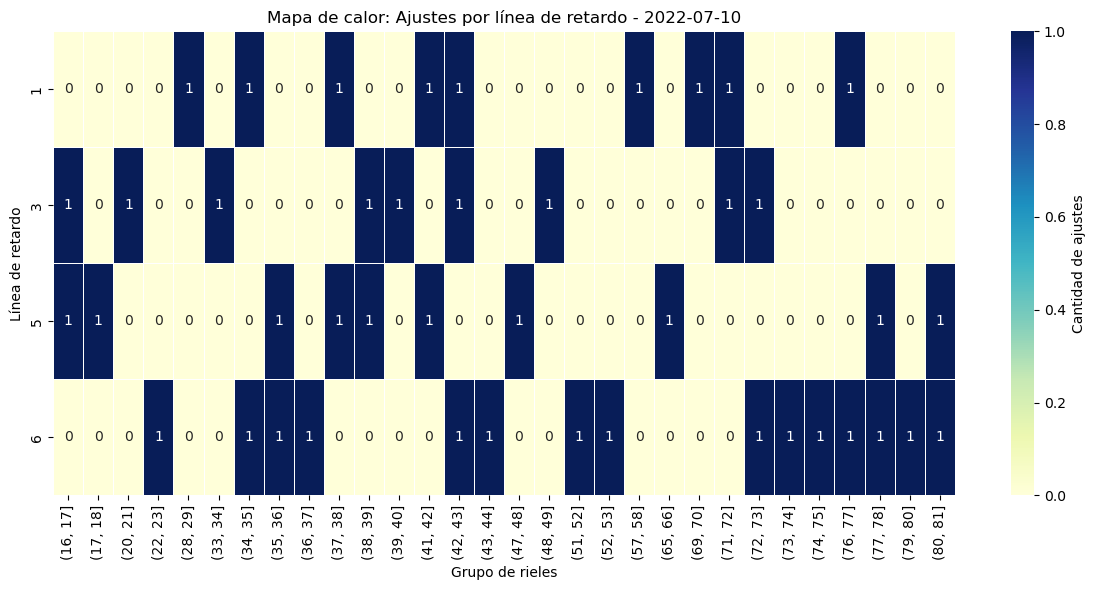

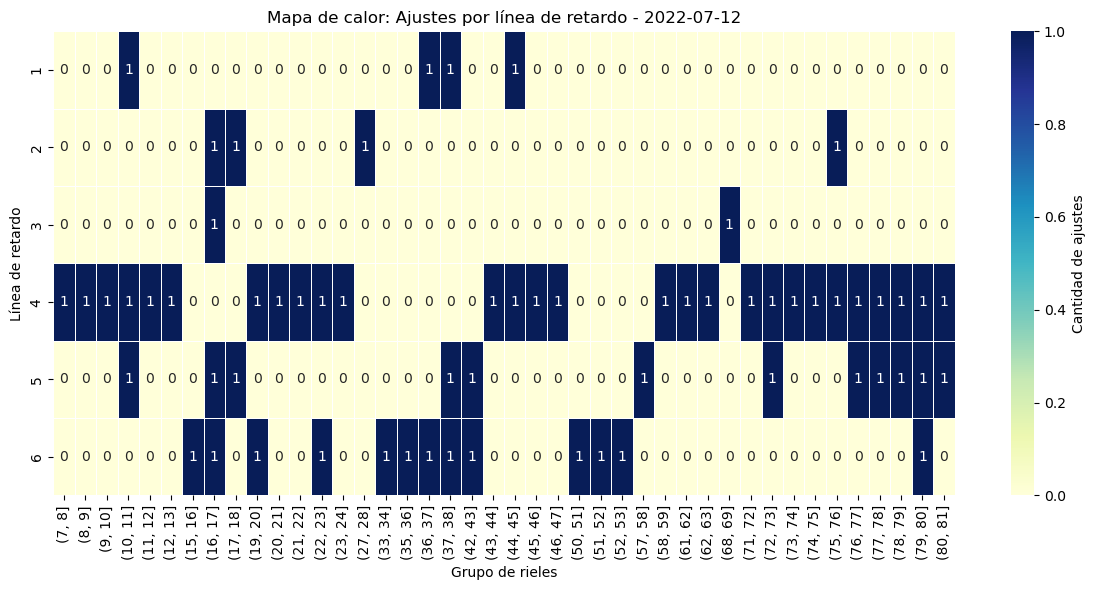

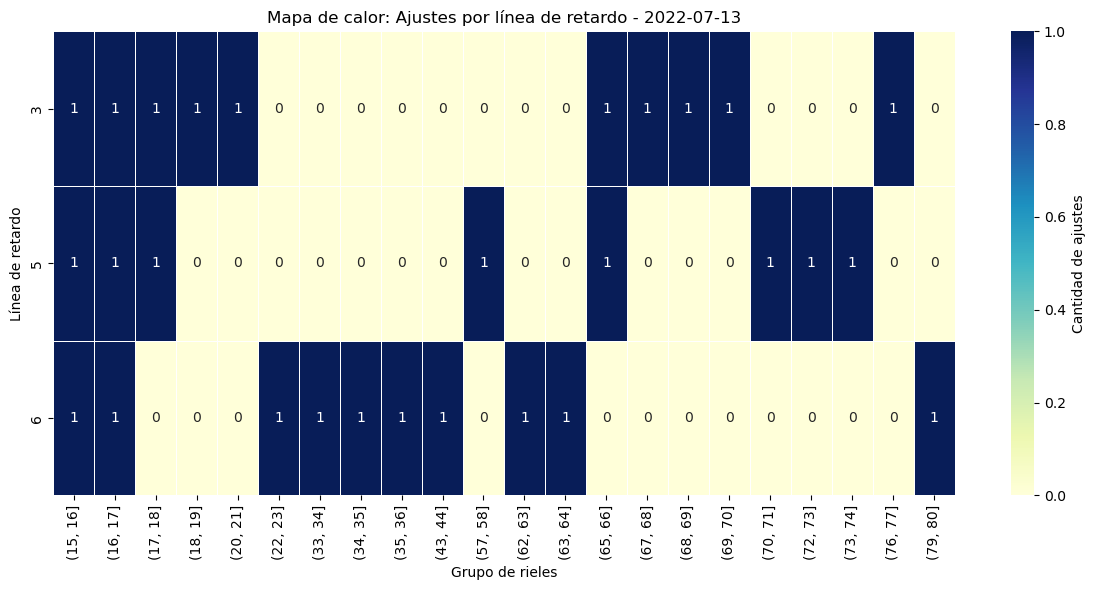

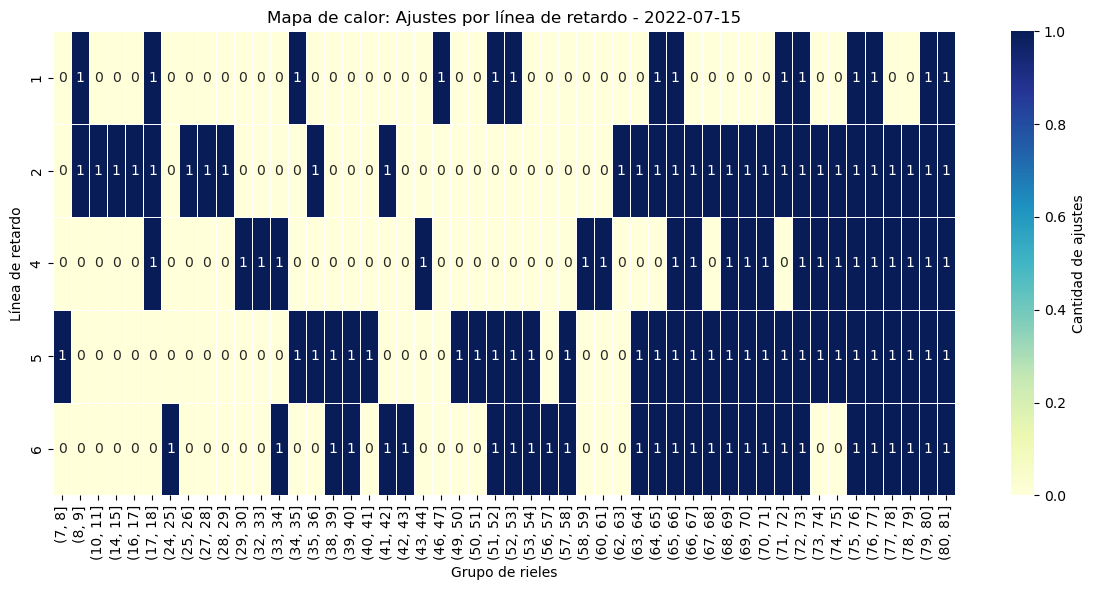

In [ ]:
df_final["Timestamp"] = pd.to_datetime(df_final["Timestamp"])

for fecha in sorted(df_final["Timestamp"].dt.date.unique()):
    df_dia = df_final[df_final["Timestamp"].dt.date == fecha].copy()

    # Rieles en intervalos de 1
    df_dia["rail_bin"] = pd.cut(df_dia["Rail number"], bins=range(0, df_dia["Rail number"].max() + 10, 1))

    # tabla de conteo
    tabla = pd.crosstab(df_dia["Delay line number"], df_dia["rail_bin"])

    # Graficar heatmap
    plt.figure(figsize=(12, 6))
    ax = sns.heatmap(tabla, annot=True, fmt="d", cmap="YlGnBu", linewidths=0.5,
                     cbar_kws={"label": "Cantidad de ajustes"})

    plt.title(f"Mapa de calor: Ajustes por línea de retardo - {fecha}")
    plt.xlabel("Grupo de rieles")
    plt.ylabel("Línea de retardo")
    plt.tight_layout()
    plt.show()


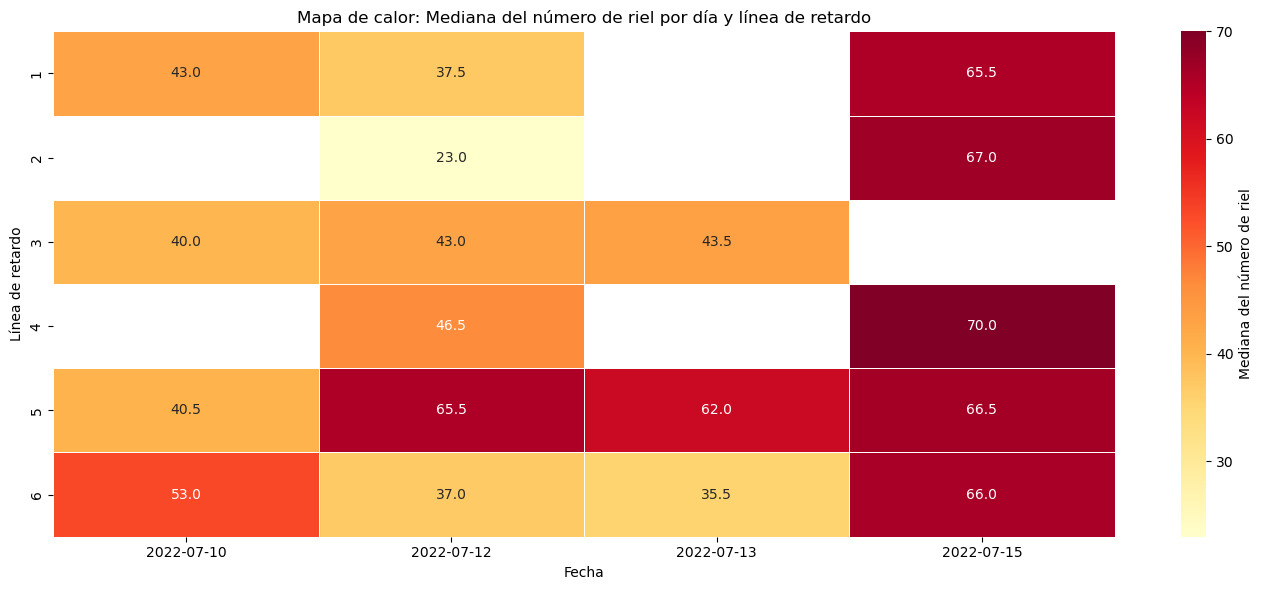

In [ ]:
df_final["Timestamp"] = pd.to_datetime(df_final["Timestamp"])

# Extraer solo la fecha
df_final["Fecha"] = df_final["Timestamp"].dt.date

# Crear tabla pivot con la mediana de Rail number
tabla_medianas = df_final.pivot_table(
    index="Delay line number",
    columns="Fecha",
    values="Rail number",
    aggfunc="median" # Se solicitó hacerlo con esta función pensando en 20 días
)

# Graficar heatmap
plt.figure(figsize=(14, 6))
sns.heatmap(tabla_medianas, annot=True, fmt=".1f", cmap="YlOrRd", linewidths=0.5,
            cbar_kws={"label": "Mediana del número de riel"})

plt.title("Mapa de calor: Mediana del número de riel por día y línea de retardo")
plt.xlabel("Fecha")
plt.ylabel("Línea de retardo")
plt.tight_layout()
plt.show()


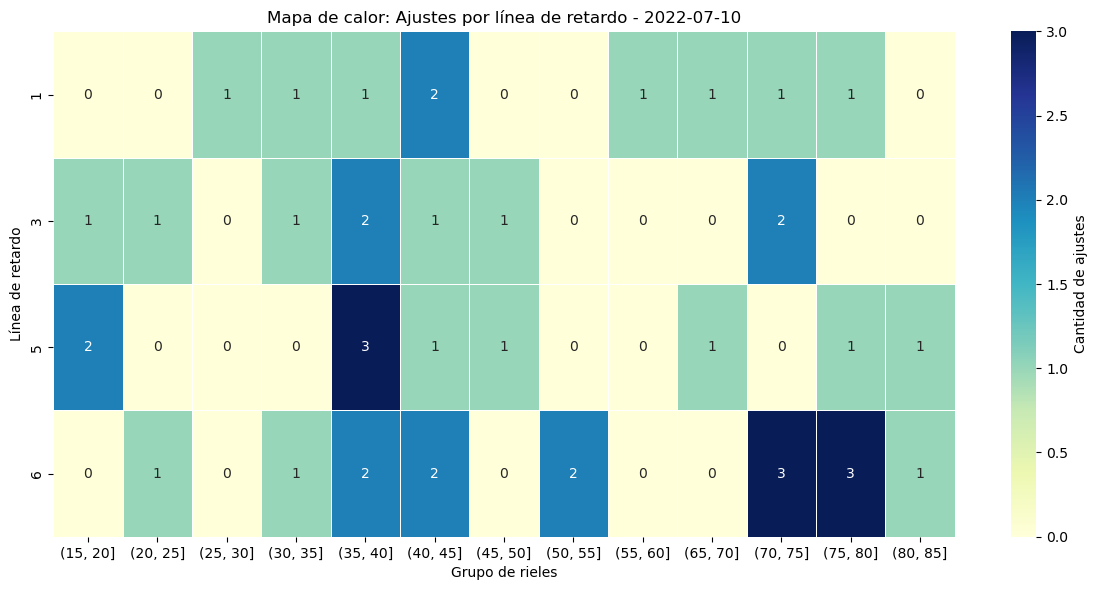

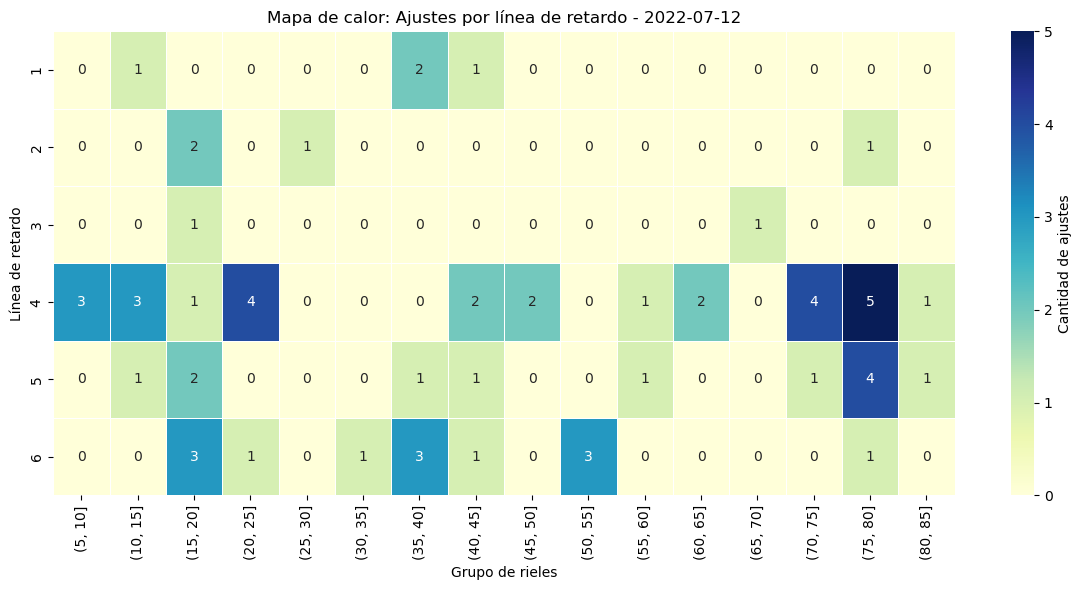

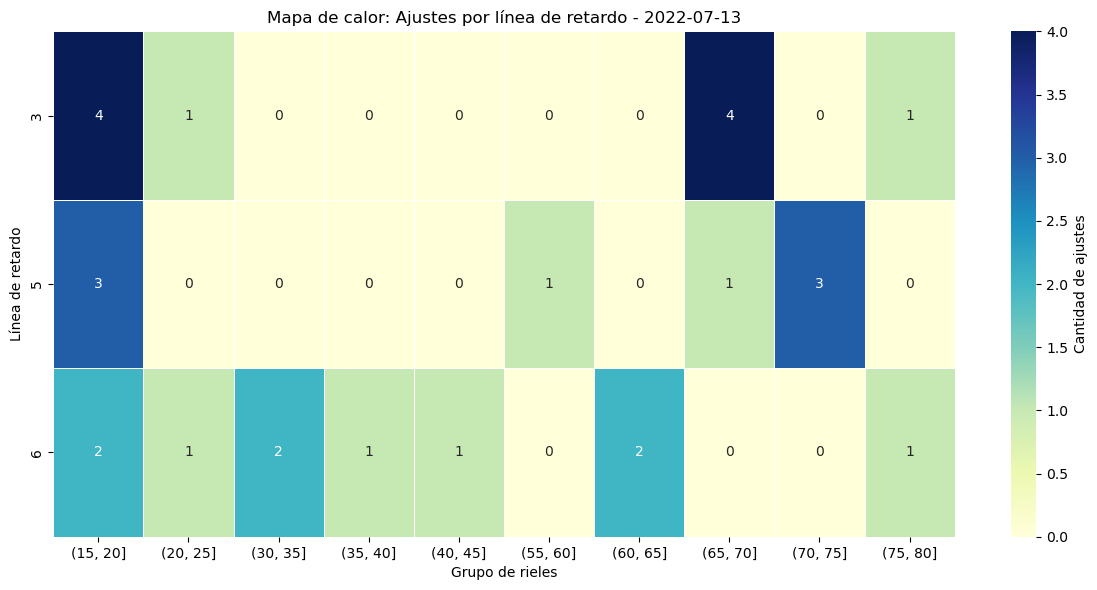

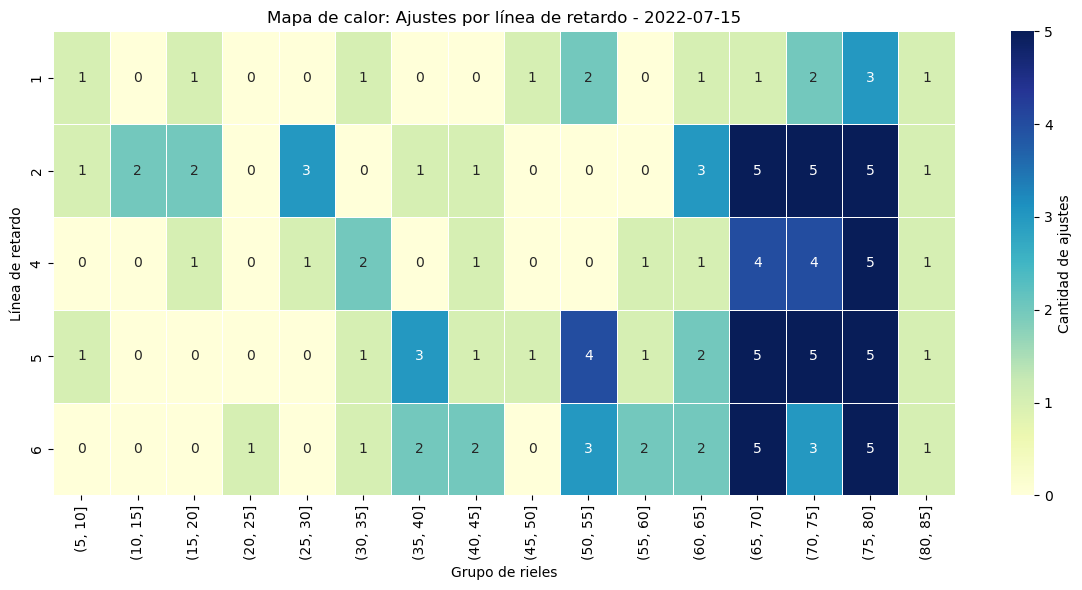

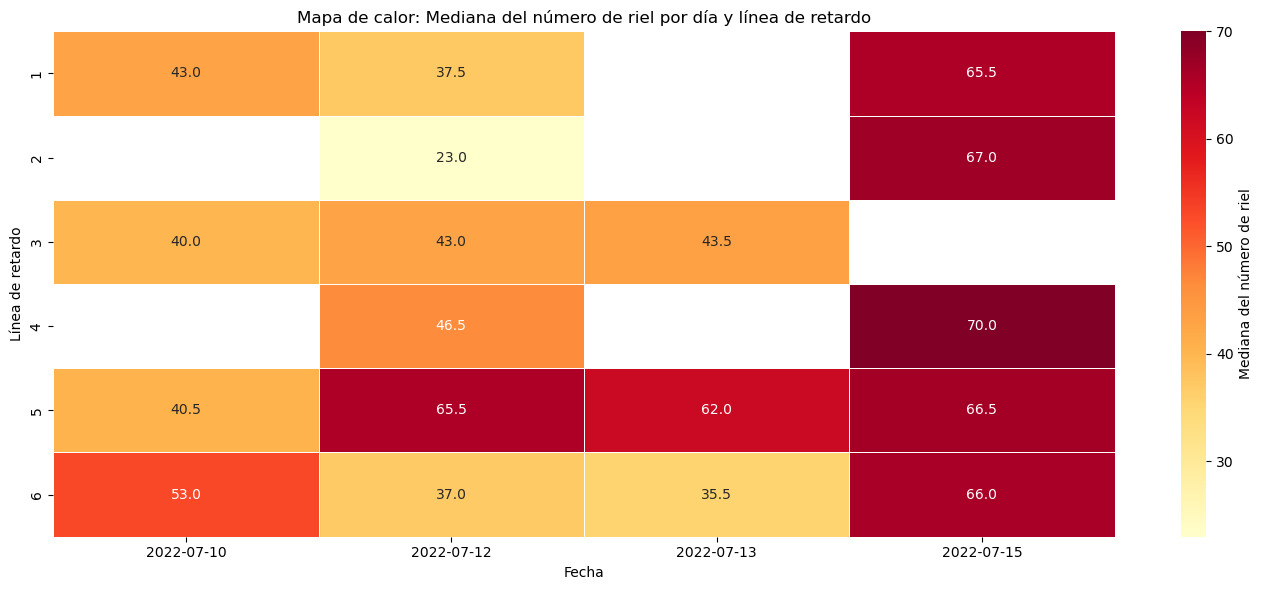

In [ ]:
# Heatmap 1 y 2 unidos

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Formato datetime asegurado
if not pd.api.types.is_datetime64_any_dtype(df_final["Timestamp"]):
    df_final["Timestamp"] = pd.to_datetime(df_final["Timestamp"])
df_final["Fecha"] = df_final["Timestamp"].dt.date

# Heatmap por día
for fecha in sorted(df_final["Fecha"].unique()):
    df_dia = df_final[df_final["Fecha"] == fecha].copy()

    if df_dia["Rail number"].nunique() > 1:
        df_dia["rail_bin"] = pd.cut(df_dia["Rail number"], bins=range(0, df_dia["Rail number"].max() + 10, 5)) # Intervalos de 5
        tabla = pd.crosstab(df_dia["Delay line number"], df_dia["rail_bin"])

        plt.figure(figsize=(12, 6))
        ax = sns.heatmap(tabla, annot=True, fmt="d", cmap="YlGnBu", linewidths=0.5,
                             cbar_kws={"label": "Cantidad de ajustes"})
        plt.title(f"Mapa de calor: Ajustes por línea de retardo - {fecha}")
        plt.xlabel("Grupo de rieles")
        plt.ylabel("Línea de retardo")
        plt.tight_layout()
        plt.show()

# Heatmap resumen con mediana
tabla_medianas = df_final.pivot_table(
    index="Delay line number",
    columns="Fecha",
    values="Rail number",
    aggfunc="median"
)

plt.figure(figsize=(14, 6))
sns.heatmap(tabla_medianas, annot=True, fmt=".1f", cmap="YlOrRd", linewidths=0.5,
                cbar_kws={"label": "Mediana del número de riel"})
plt.title("Mapa de calor: Mediana del número de riel por día y línea de retardo")
plt.xlabel("Fecha")
plt.ylabel("Línea de retardo")
plt.tight_layout()
plt.show()

# Gráficos con plotly

In [ ]:
# Heatmap 1 con plotly

import plotly.express as px
import pandas as pd

# Formato datetime asegurado
df_final["Timestamp"] = pd.to_datetime(df_final["Timestamp"])
df_final["Fecha"] = df_final["Timestamp"].dt.date

for fecha in sorted(df_final["Fecha"].unique()):
    df_dia = df_final[df_final["Fecha"] == fecha].copy()

    if df_dia["Rail number"].nunique() > 1:
        df_dia["rail_bin"] = pd.cut(df_dia["Rail number"], bins=range(0, df_dia["Rail number"].max() + 10, 5))
        tabla = pd.crosstab(df_dia["Delay line number"], df_dia["rail_bin"])

        fig = px.imshow(
            tabla.values,
            labels=dict(x="Grupo de rieles", y="Línea de retardo", color="Cantidad de ajustes"),
            x=[str(c) for c in tabla.columns],
            y=tabla.index,
            text_auto=True,
            color_continuous_scale="YlGnBu",
            aspect="auto",
            title=f"Mapa de calor: Ajustes por línea de retardo - {fecha}"
        )
        fig.update_layout(xaxis_title="Grupo de rieles", yaxis_title="Línea de retardo")
        fig.show()

In [ ]:
# Heatmap 2 con plotly
tabla_medianas = df_final.pivot_table(
    index="Delay line number",
    columns="Fecha",
    values="Rail number",
    aggfunc="median"
)

fig = px.imshow(
    tabla_medianas.values,
    labels=dict(x="Fecha", y="Línea de retardo", color="Mediana del número de riel"),
    x=[str(c) for c in tabla_medianas.columns],
    y=tabla_medianas.index,
    text_auto=".1f",
    color_continuous_scale="YlOrRd",
    aspect="auto",
    title="Mapa de calor: Mediana del número de riel por día y línea de retardo"
)
fig.update_layout(xaxis_title="Fecha", yaxis_title="Línea de retardo")
fig.show()